# Import Libraries:

In [81]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

# Shows plots in jupyter notebook
%matplotlib inline

# Set plot style
sns.set(color_codes=True)

#Data Loading

In [51]:
df = pd.read_csv('/content/drive/MyDrive/BCG Gamma/cleaned_eda.csv')

In [52]:
df.head(3)

,Unnamed: 0,id,channel_sales,cons_12m,cons_gas_12m,cons_last_month,date_activ,date_end,date_modif_prod,date_renewal,...,origin_up,pow_max,churn,price_date,price_off_peak_var,price_peak_var,price_mid_peak_var,price_off_peak_fix,price_peak_fix,price_mid_peak_fix
0,0,24011ae4ebbe3035111d65fa7c15bc57,foosdfpfkusacimwkcsosbicdxkicaua,0,54946,0,2013-06-15,2016-06-15,2015-11-01,2015-06-23,...,lxidpiddsbxsbosboudacockeimpuepw,43.648,1,2015-01-01,0.125976,0.103395,0.071536,40.565969,24.339581,16.226389
1,1,24011ae4ebbe3035111d65fa7c15bc57,foosdfpfkusacimwkcsosbicdxkicaua,0,54946,0,2013-06-15,2016-06-15,2015-11-01,2015-06-23,...,lxidpiddsbxsbosboudacockeimpuepw,43.648,1,2015-02-01,0.125976,0.103395,0.071536,40.565969,24.339581,16.226389
2,2,24011ae4ebbe3035111d65fa7c15bc57,foosdfpfkusacimwkcsosbicdxkicaua,0,54946,0,2013-06-15,2016-06-15,2015-11-01,2015-06-23,...,lxidpiddsbxsbosboudacockeimpuepw,43.648,1,2015-03-01,0.125976,0.103395,0.071536,40.565973,24.339578,16.226383


In [53]:
def convert_to_datetime(data: pd.DataFrame = None, column: str = None):

  dummy = data.copy()
  dummy[column] = pd.to_datetime(dummy[column], format='%Y-%m-%d %H:%M:%S')
  return dummy

In [54]:
df = convert_to_datetime(df, 'date_activ')
df = convert_to_datetime(df, 'date_end')
df = convert_to_datetime(df, 'date_modif_prod')
df = convert_to_datetime(df, 'date_renewal')
df = convert_to_datetime(df, 'price_date')

# Feature Engineering

**Difference between off-peak prices in December and preceding January**
---
Below is the code created by your colleague to calculate the feature described above. Use this code to re-create this feature and then think about ways to build on this feature to create features with predictive power

In [55]:
# Group off-peak prices by companies and month
monthly_price_by_id = df.groupby(['id', 'price_date']).agg({'price_off_peak_var': 'mean', 'price_off_peak_fix': 'mean'}).reset_index()

# Get january and december prices
jan_prices = monthly_price_by_id.groupby('id').first().reset_index()
dec_prices = monthly_price_by_id.groupby('id').last().reset_index()

# Calculate the difference
diff = pd.merge(dec_prices.rename(columns={'price_off_peak_var': 'dec_1', 'price_off_peak_fix': 'dec_2'}), jan_prices.drop(columns='price_date'), on='id')
diff['offpeak_diff_dec_january_energy'] = diff['dec_1'] - diff['price_off_peak_var']
diff['offpeak_diff_dec_january_power'] = diff['dec_2'] - diff['price_off_peak_fix']
diff = diff[['id', 'offpeak_diff_dec_january_energy','offpeak_diff_dec_january_power']]
diff.head()

,id,offpeak_diff_dec_january_energy,offpeak_diff_dec_january_power
0,0002203ffbb812588b632b9e628cc38d,-0.006192,0.162916
1,0004351ebdd665e6ee664792efc4fd13,-0.004104,0.177779
2,0010bcc39e42b3c2131ed2ce55246e3c,0.050443,1.500000
3,00114d74e963e47177db89bc70108537,-0.003994,-0.000001
4,0013f326a839a2f6ad87a1859952d227,-0.006171,0.000000


In [56]:
df = pd.merge(df, diff, on='id')
df.head()

,Unnamed: 0,id,channel_sales,cons_12m,cons_gas_12m,cons_last_month,date_activ,date_end,date_modif_prod,date_renewal,...,churn,price_date,price_off_peak_var,price_peak_var,price_mid_peak_var,price_off_peak_fix,price_peak_fix,price_mid_peak_fix,offpeak_diff_dec_january_energy,offpeak_diff_dec_january_power
0,0,24011ae4ebbe3035111d65fa7c15bc57,foosdfpfkusacimwkcsosbicdxkicaua,0,54946,0,2013-06-15,2016-06-15,2015-11-01,2015-06-23,...,1,2015-01-01,0.125976,0.103395,0.071536,40.565969,24.339581,16.226389,0.020057,3.700961
1,1,24011ae4ebbe3035111d65fa7c15bc57,foosdfpfkusacimwkcsosbicdxkicaua,0,54946,0,2013-06-15,2016-06-15,2015-11-01,2015-06-23,...,1,2015-02-01,0.125976,0.103395,0.071536,40.565969,24.339581,16.226389,0.020057,3.700961
2,2,24011ae4ebbe3035111d65fa7c15bc57,foosdfpfkusacimwkcsosbicdxkicaua,0,54946,0,2013-06-15,2016-06-15,2015-11-01,2015-06-23,...,1,2015-03-01,0.125976,0.103395,0.071536,40.565973,24.339578,16.226383,0.020057,3.700961
3,3,24011ae4ebbe3035111d65fa7c15bc57,foosdfpfkusacimwkcsosbicdxkicaua,0,54946,0,2013-06-15,2016-06-15,2015-11-01,2015-06-23,...,1,2015-04-01,0.125976,0.103395,0.071536,40.565973,24.339578,16.226383,0.020057,3.700961
4,4,24011ae4ebbe3035111d65fa7c15bc57,foosdfpfkusacimwkcsosbicdxkicaua,0,54946,0,2013-06-15,2016-06-15,2015-11-01,2015-06-23,...,1,2015-05-01,0.125976,0.103395,0.071536,40.565973,24.339578,16.226383,0.020057,3.700961


Average Changes in prices across period:
---
To calculate the average changes in prices based on individual periods rather than the entire year.

This feature helps in addding granularity based on the existing feature that was created to calculate the **Difference between off-peak prices in December and preceding January**. The approach here is to take individual periods into consideration other than the entire year. The period that were taken into consideration are #Peak, #Off-Peak, #Mid-Peak.

In [57]:
# Aggregate average prices per period by company
mean_prices = df.groupby(['id']).agg({
    'price_off_peak_var': 'mean', 
    'price_peak_var': 'mean', 
    'price_mid_peak_var': 'mean',
    'price_off_peak_fix': 'mean',
    'price_peak_fix': 'mean',
    'price_mid_peak_fix': 'mean'    
}).reset_index()
     

# Calculate the mean difference between independent periods
mean_prices['off_peak_peak_var_mean_diff'] = mean_prices['price_off_peak_var'] - mean_prices['price_peak_var']
mean_prices['peak_mid_peak_var_mean_diff'] = mean_prices['price_peak_var'] - mean_prices['price_mid_peak_var']
mean_prices['off_peak_mid_peak_var_mean_diff'] = mean_prices['price_off_peak_var'] - mean_prices['price_mid_peak_var']
mean_prices['off_peak_peak_fix_mean_diff'] = mean_prices['price_off_peak_fix'] - mean_prices['price_peak_fix']
mean_prices['peak_mid_peak_fix_mean_diff'] = mean_prices['price_peak_fix'] - mean_prices['price_mid_peak_fix']
mean_prices['off_peak_mid_peak_fix_mean_diff'] = mean_prices['price_off_peak_fix'] - mean_prices['price_mid_peak_fix']
     

columns = [
    'id', 
    'off_peak_peak_var_mean_diff',
    'peak_mid_peak_var_mean_diff', 
    'off_peak_mid_peak_var_mean_diff',
    'off_peak_peak_fix_mean_diff', 
    'peak_mid_peak_fix_mean_diff', 
    'off_peak_mid_peak_fix_mean_diff'
]
df = pd.merge(df, mean_prices[columns], on='id')
df.head()
     

,Unnamed: 0,id,channel_sales,cons_12m,cons_gas_12m,cons_last_month,date_activ,date_end,date_modif_prod,date_renewal,...,price_peak_fix,price_mid_peak_fix,offpeak_diff_dec_january_energy,offpeak_diff_dec_january_power,off_peak_peak_var_mean_diff,peak_mid_peak_var_mean_diff,off_peak_mid_peak_var_mean_diff,off_peak_peak_fix_mean_diff,peak_mid_peak_fix_mean_diff,off_peak_mid_peak_fix_mean_diff
0,0,24011ae4ebbe3035111d65fa7c15bc57,foosdfpfkusacimwkcsosbicdxkicaua,0,54946,0,2013-06-15,2016-06-15,2015-11-01,2015-06-23,...,24.339581,16.226389,0.020057,3.700961,0.024038,0.034219,0.058257,18.590255,7.45067,26.040925
1,1,24011ae4ebbe3035111d65fa7c15bc57,foosdfpfkusacimwkcsosbicdxkicaua,0,54946,0,2013-06-15,2016-06-15,2015-11-01,2015-06-23,...,24.339581,16.226389,0.020057,3.700961,0.024038,0.034219,0.058257,18.590255,7.45067,26.040925
2,2,24011ae4ebbe3035111d65fa7c15bc57,foosdfpfkusacimwkcsosbicdxkicaua,0,54946,0,2013-06-15,2016-06-15,2015-11-01,2015-06-23,...,24.339578,16.226383,0.020057,3.700961,0.024038,0.034219,0.058257,18.590255,7.45067,26.040925
3,3,24011ae4ebbe3035111d65fa7c15bc57,foosdfpfkusacimwkcsosbicdxkicaua,0,54946,0,2013-06-15,2016-06-15,2015-11-01,2015-06-23,...,24.339578,16.226383,0.020057,3.700961,0.024038,0.034219,0.058257,18.590255,7.45067,26.040925
4,4,24011ae4ebbe3035111d65fa7c15bc57,foosdfpfkusacimwkcsosbicdxkicaua,0,54946,0,2013-06-15,2016-06-15,2015-11-01,2015-06-23,...,24.339578,16.226383,0.020057,3.700961,0.024038,0.034219,0.058257,18.590255,7.45067,26.040925


Maximum Changes in prices across period:
---
To calculate the average changes in prices based on individual periods rather than the entire year.

Looking at Power Co's customer's point of view it could quiet annoying when there is a sudden spike in prices. That's when they'd start looking for other vendors in same space. It is an interesting feature to use.

In [58]:
# Aggregate average prices per period by company
mean_prices_by_month = df.groupby(['id', 'price_date']).agg({
    'price_off_peak_var': 'mean', 
    'price_peak_var': 'mean', 
    'price_mid_peak_var': 'mean',
    'price_off_peak_fix': 'mean',
    'price_peak_fix': 'mean',
    'price_mid_peak_fix': 'mean'    
}).reset_index()
     

# Calculate the mean difference between independant periods
mean_prices_by_month['off_peak_peak_var_mean_diff'] = mean_prices_by_month['price_off_peak_var'] - mean_prices_by_month['price_peak_var']
mean_prices_by_month['peak_mid_peak_var_mean_diff'] = mean_prices_by_month['price_peak_var'] - mean_prices_by_month['price_mid_peak_var']
mean_prices_by_month['off_peak_mid_peak_var_mean_diff'] = mean_prices_by_month['price_off_peak_var'] - mean_prices_by_month['price_mid_peak_var']
mean_prices_by_month['off_peak_peak_fix_mean_diff'] = mean_prices_by_month['price_off_peak_fix'] - mean_prices_by_month['price_peak_fix']
mean_prices_by_month['peak_mid_peak_fix_mean_diff'] = mean_prices_by_month['price_peak_fix'] - mean_prices_by_month['price_mid_peak_fix']
mean_prices_by_month['off_peak_mid_peak_fix_mean_diff'] = mean_prices_by_month['price_off_peak_fix'] - mean_prices_by_month['price_mid_peak_fix']
     

#maximum monthly difference across time periods
max_diff_across_periods_months = mean_prices_by_month.groupby(['id']).agg({
    'off_peak_peak_var_mean_diff': 'max',
    'peak_mid_peak_var_mean_diff': 'max',
    'off_peak_mid_peak_var_mean_diff': 'max',
    'off_peak_peak_fix_mean_diff': 'max',
    'peak_mid_peak_fix_mean_diff': 'max',
    'off_peak_mid_peak_fix_mean_diff': 'max'
}).reset_index().rename(
    columns={
        'off_peak_peak_var_mean_diff': 'off_peak_peak_var_max_monthly_diff',
        'peak_mid_peak_var_mean_diff': 'peak_mid_peak_var_max_monthly_diff',
        'off_peak_mid_peak_var_mean_diff': 'off_peak_mid_peak_var_max_monthly_diff',
        'off_peak_peak_fix_mean_diff': 'off_peak_peak_fix_max_monthly_diff',
        'peak_mid_peak_fix_mean_diff': 'peak_mid_peak_fix_max_monthly_diff',
        'off_peak_mid_peak_fix_mean_diff': 'off_peak_mid_peak_fix_max_monthly_diff'
    }
)
     

columns = [
    'id',
    'off_peak_peak_var_max_monthly_diff',
    'peak_mid_peak_var_max_monthly_diff',
    'off_peak_mid_peak_var_max_monthly_diff',
    'off_peak_peak_fix_max_monthly_diff',
    'peak_mid_peak_fix_max_monthly_diff',
    'off_peak_mid_peak_fix_max_monthly_diff'
]

df = pd.merge(df, max_diff_across_periods_months[columns], on='id')
df.head()
     

,Unnamed: 0,id,channel_sales,cons_12m,cons_gas_12m,cons_last_month,date_activ,date_end,date_modif_prod,date_renewal,...,off_peak_mid_peak_var_mean_diff,off_peak_peak_fix_mean_diff,peak_mid_peak_fix_mean_diff,off_peak_mid_peak_fix_mean_diff,off_peak_peak_var_max_monthly_diff,peak_mid_peak_var_max_monthly_diff,off_peak_mid_peak_var_max_monthly_diff,off_peak_peak_fix_max_monthly_diff,peak_mid_peak_fix_max_monthly_diff,off_peak_mid_peak_fix_max_monthly_diff
0,0,24011ae4ebbe3035111d65fa7c15bc57,foosdfpfkusacimwkcsosbicdxkicaua,0,54946,0,2013-06-15,2016-06-15,2015-11-01,2015-06-23,...,0.058257,18.590255,7.45067,26.040925,0.06055,0.085483,0.146033,44.26693,8.145775,44.26693
1,1,24011ae4ebbe3035111d65fa7c15bc57,foosdfpfkusacimwkcsosbicdxkicaua,0,54946,0,2013-06-15,2016-06-15,2015-11-01,2015-06-23,...,0.058257,18.590255,7.45067,26.040925,0.06055,0.085483,0.146033,44.26693,8.145775,44.26693
2,2,24011ae4ebbe3035111d65fa7c15bc57,foosdfpfkusacimwkcsosbicdxkicaua,0,54946,0,2013-06-15,2016-06-15,2015-11-01,2015-06-23,...,0.058257,18.590255,7.45067,26.040925,0.06055,0.085483,0.146033,44.26693,8.145775,44.26693
3,3,24011ae4ebbe3035111d65fa7c15bc57,foosdfpfkusacimwkcsosbicdxkicaua,0,54946,0,2013-06-15,2016-06-15,2015-11-01,2015-06-23,...,0.058257,18.590255,7.45067,26.040925,0.06055,0.085483,0.146033,44.26693,8.145775,44.26693
4,4,24011ae4ebbe3035111d65fa7c15bc57,foosdfpfkusacimwkcsosbicdxkicaua,0,54946,0,2013-06-15,2016-06-15,2015-11-01,2015-06-23,...,0.058257,18.590255,7.45067,26.040925,0.06055,0.085483,0.146033,44.26693,8.145775,44.26693


Tenure:
---
How long has the companies been in contract with PowerCo.

It can be seen the companies that stay for 4 months or less are more likely to churn rather than the ones that stayed for longer. 

In [59]:
df['tenure'] = ((df['date_end'] - df['date_activ'])/ np.timedelta64(1, 'Y')).astype(int)
df.groupby(['tenure']).agg({'churn': 'mean'}).sort_values(by='churn', ascending=False)

,churn
tenure,
3,0.143612
2,0.132656
4,0.125711
13,0.095238
5,0.085298
12,0.083333
6,0.080687
7,0.073354
11,0.063584


Transforming Dates to Months:
---
Dates as a datetime object are not useful for a predictive model, so we needed to use the datetimes to create some other features that may hold some predictive power.

There are three important features that I'd like to create:

- As a cutomer to PowerCo there might be be different possibilities to look out for better deals, see out of contract and sign another one OR there might be some charges that that a customer might like to opt out of. For this `#months_to_end` could be an interesting feature.

- If a customer has received high level customer service to change, renew or update their existing service. It could indicate a positive sign that they have high level engagement so `#months_modif_prod` could be potentially a great feature.

- Finally how long has it been since has a customer has renewed their contract with PowerCo is a sign of level of commitment a customer has to PowerCo `#months_renewal` is good feature to include.

In [60]:
def convert_months(reference_date, df, column):
    """
    Input a column with timedeltas and return months
    """
    time_delta = reference_date - df[column]
    months = (time_delta / np.timedelta64(1, 'M')).astype(int)
    return months
     


In [61]:
# Create reference date
reference_date = datetime(2016, 1, 1)

df['months_activ'] = convert_months(reference_date, df, 'date_activ')
df['months_to_end'] = -convert_months(reference_date, df, 'date_end')
df['months_modif_prod'] = convert_months(reference_date, df, 'date_modif_prod')
df['months_renewal'] = convert_months(reference_date, df, 'date_renewal')
     

In [62]:

#no longer need the datetime columns that we used for feature engineering, so we can drop them
remove = [
    'date_activ',
    'date_end',
    'date_modif_prod',
    'date_renewal',
    'price_date'
]

df = df.drop(columns=remove)
df.head()

,Unnamed: 0,id,channel_sales,cons_12m,cons_gas_12m,cons_last_month,forecast_cons_12m,forecast_cons_year,forecast_discount_energy,forecast_meter_rent_12m,...,peak_mid_peak_var_max_monthly_diff,off_peak_mid_peak_var_max_monthly_diff,off_peak_peak_fix_max_monthly_diff,peak_mid_peak_fix_max_monthly_diff,off_peak_mid_peak_fix_max_monthly_diff,tenure,months_activ,months_to_end,months_modif_prod,months_renewal
0,0,24011ae4ebbe3035111d65fa7c15bc57,foosdfpfkusacimwkcsosbicdxkicaua,0,54946,0,0.0,0,0.0,1.78,...,0.085483,0.146033,44.26693,8.145775,44.26693,3,30,5,2,6
1,1,24011ae4ebbe3035111d65fa7c15bc57,foosdfpfkusacimwkcsosbicdxkicaua,0,54946,0,0.0,0,0.0,1.78,...,0.085483,0.146033,44.26693,8.145775,44.26693,3,30,5,2,6
2,2,24011ae4ebbe3035111d65fa7c15bc57,foosdfpfkusacimwkcsosbicdxkicaua,0,54946,0,0.0,0,0.0,1.78,...,0.085483,0.146033,44.26693,8.145775,44.26693,3,30,5,2,6
3,3,24011ae4ebbe3035111d65fa7c15bc57,foosdfpfkusacimwkcsosbicdxkicaua,0,54946,0,0.0,0,0.0,1.78,...,0.085483,0.146033,44.26693,8.145775,44.26693,3,30,5,2,6
4,4,24011ae4ebbe3035111d65fa7c15bc57,foosdfpfkusacimwkcsosbicdxkicaua,0,54946,0,0.0,0,0.0,1.78,...,0.085483,0.146033,44.26693,8.145775,44.26693,3,30,5,2,6


Cutonmers that have Gas:
---
Customers that have subcribed to Gas are high likely to chrun other than the ones that did!


In [63]:
df['has_gas'] = df['has_gas'].replace(['t', 'f'], [1, 0])
df.groupby(['has_gas']).agg({'churn': 'mean'})
     

,churn
has_gas,
0,0.100437
1,0.081925


Fixing the Categorical Data_types:
---
As a predictive model cannot take in categorical values it is impotant to remove those.


Channel Sales

In [64]:
df['channel_sales'] = df['channel_sales'].astype('category')
df['channel_sales'].value_counts()

foosdfpfkusacimwkcsosbicdxkicaua    80971
MISSING                             44684
lmkebamcaaclubfxadlmueccxoimlema    22105
usilxuppasemubllopkaafesmlibmsdf    16486
ewpakwlliwisiwduibdlfmalxowmwpci    10712
sddiedcslfslkckwlfkdpoeeailfpeds      131
epumfxlbckeskwekxbiuasklxalciiuu       36
fixdbufsefwooaasfcxdxadsiekoceaa       24
Name: channel_sales, dtype: int64

In [65]:
#dropping variables
df = pd.get_dummies(df, columns=['channel_sales'], prefix='channel')
df = df.drop(columns=['channel_sddiedcslfslkckwlfkdpoeeailfpeds', 'channel_epumfxlbckeskwekxbiuasklxalciiuu', 'channel_fixdbufsefwooaasfcxdxadsiekoceaa'])
df.head()

,Unnamed: 0,id,cons_12m,cons_gas_12m,cons_last_month,forecast_cons_12m,forecast_cons_year,forecast_discount_energy,forecast_meter_rent_12m,forecast_price_energy_off_peak,...,tenure,months_activ,months_to_end,months_modif_prod,months_renewal,channel_MISSING,channel_ewpakwlliwisiwduibdlfmalxowmwpci,channel_foosdfpfkusacimwkcsosbicdxkicaua,channel_lmkebamcaaclubfxadlmueccxoimlema,channel_usilxuppasemubllopkaafesmlibmsdf
0,0,24011ae4ebbe3035111d65fa7c15bc57,0,54946,0,0.0,0,0.0,1.78,0.114481,...,3,30,5,2,6,0,0,1,0,0
1,1,24011ae4ebbe3035111d65fa7c15bc57,0,54946,0,0.0,0,0.0,1.78,0.114481,...,3,30,5,2,6,0,0,1,0,0
2,2,24011ae4ebbe3035111d65fa7c15bc57,0,54946,0,0.0,0,0.0,1.78,0.114481,...,3,30,5,2,6,0,0,1,0,0
3,3,24011ae4ebbe3035111d65fa7c15bc57,0,54946,0,0.0,0,0.0,1.78,0.114481,...,3,30,5,2,6,0,0,1,0,0
4,4,24011ae4ebbe3035111d65fa7c15bc57,0,54946,0,0.0,0,0.0,1.78,0.114481,...,3,30,5,2,6,0,0,1,0,0


Origin_up


In [66]:
df['origin_up'] = df['origin_up'].astype('category')
df['origin_up'].value_counts()
     

lxidpiddsbxsbosboudacockeimpuepw    85086
kamkkxfxxuwbdslkwifmmcsiusiuosws    51503
ldkssxwpmemidmecebumciepifcamkci    37757
MISSING                               767
usapbepcfoloekilkwsdiboslwaxobdp       24
ewxeelcelemmiwuafmddpobolfuxioce       12
Name: origin_up, dtype: int64

In [67]:
#dropping variables
df = pd.get_dummies(df, columns=['origin_up'], prefix='origin')
df = df.drop(columns=['origin_MISSING', 'origin_usapbepcfoloekilkwsdiboslwaxobdp', 'origin_ewxeelcelemmiwuafmddpobolfuxioce'])
df.head()

,Unnamed: 0,id,cons_12m,cons_gas_12m,cons_last_month,forecast_cons_12m,forecast_cons_year,forecast_discount_energy,forecast_meter_rent_12m,forecast_price_energy_off_peak,...,months_modif_prod,months_renewal,channel_MISSING,channel_ewpakwlliwisiwduibdlfmalxowmwpci,channel_foosdfpfkusacimwkcsosbicdxkicaua,channel_lmkebamcaaclubfxadlmueccxoimlema,channel_usilxuppasemubllopkaafesmlibmsdf,origin_kamkkxfxxuwbdslkwifmmcsiusiuosws,origin_ldkssxwpmemidmecebumciepifcamkci,origin_lxidpiddsbxsbosboudacockeimpuepw
0,0,24011ae4ebbe3035111d65fa7c15bc57,0,54946,0,0.0,0,0.0,1.78,0.114481,...,2,6,0,0,1,0,0,0,0,1
1,1,24011ae4ebbe3035111d65fa7c15bc57,0,54946,0,0.0,0,0.0,1.78,0.114481,...,2,6,0,0,1,0,0,0,0,1
2,2,24011ae4ebbe3035111d65fa7c15bc57,0,54946,0,0.0,0,0.0,1.78,0.114481,...,2,6,0,0,1,0,0,0,0,1
3,3,24011ae4ebbe3035111d65fa7c15bc57,0,54946,0,0.0,0,0.0,1.78,0.114481,...,2,6,0,0,1,0,0,0,0,1
4,4,24011ae4ebbe3035111d65fa7c15bc57,0,54946,0,0.0,0,0.0,1.78,0.114481,...,2,6,0,0,1,0,0,0,0,1


In [68]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 175149 entries, 0 to 175148
Data columns (total 54 columns):
 #   Column                                    Non-Null Count   Dtype  
---  ------                                    --------------   -----  
 0   Unnamed: 0                                175149 non-null  int64  
 1   id                                        175149 non-null  object 
 2   cons_12m                                  175149 non-null  int64  
 3   cons_gas_12m                              175149 non-null  int64  
 4   cons_last_month                           175149 non-null  int64  
 5   forecast_cons_12m                         175149 non-null  float64
 6   forecast_cons_year                        175149 non-null  int64  
 7   forecast_discount_energy                  175149 non-null  float64
 8   forecast_meter_rent_12m                   175149 non-null  float64
 9   forecast_price_energy_off_peak            175149 non-null  float64
 10  forecast_price_energ

Numerical Data - Transformation:
---
While performing the EDA its was seen the data was highly skewed. The skewed data needs treatment as the predictive models usually have certain assumstion inherent that considers all data to be evenly distrubuted.


In [71]:
skewed = [
    'cons_12m', 
    'cons_gas_12m', 
    'cons_last_month',
    'forecast_cons_12m', 
    'forecast_cons_year', 
    'forecast_discount_energy',
    'forecast_meter_rent_12m', 
    'forecast_price_energy_off_peak',
    'forecast_price_energy_peak', 
    'forecast_price_pow_off_peak'
]

#using log 10 to Transformation
df["cons_12m"] = np.log10(df["cons_12m"] + 1)
df["cons_gas_12m"] = np.log10(df["cons_gas_12m"] + 1)
df["cons_last_month"] = np.log10(df["cons_last_month"] + 1)
df["forecast_cons_12m"] = np.log10(df["forecast_cons_12m"] + 1)
df["forecast_cons_year"] = np.log10(df["forecast_cons_year"] + 1)
df["forecast_meter_rent_12m"] = np.log10(df["forecast_meter_rent_12m"] + 1)
df["imp_cons"] = np.log10(df["imp_cons"] + 1)
     

df[skewed].describe()
     

,cons_12m,cons_gas_12m,cons_last_month,forecast_cons_12m,forecast_cons_year,forecast_discount_energy,forecast_meter_rent_12m,forecast_price_energy_off_peak,forecast_price_energy_peak,forecast_price_pow_off_peak
count,175149.000000,175149.000000,175149.000000,175149.000000,175149.000000,175149.000000,175149.000000,175149.000000,175149.000000,175149.000000
mean,4.223974,0.779107,2.264762,2.962138,1.784528,0.967028,1.517148,0.137287,0.050487,43.130229
std,0.884530,1.716895,1.769263,0.683576,1.584941,5.109025,0.571421,0.024625,0.049036,4.486779
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,3.753966,0.000000,0.000000,2.695464,0.000000,0.000000,1.235023,0.116340,0.000000,40.606701
50%,4.149712,0.000000,2.899273,3.046733,2.498311,0.000000,1.296446,0.143166,0.084138,44.311378
75%,4.610277,0.000000,3.529430,3.380455,3.242044,0.000000,2.120673,0.146348,0.098837,44.311378
max,6.792889,6.618528,5.887169,4.918575,5.243970,30.000000,2.778376,0.273963,0.195975,59.266378


Checking the Distribution of the variables.

<ipython-input-72-06a73b8bc9ae>:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot((df["cons_12m"].dropna()), ax=axs[0])
<ipython-input-72-06a73b8bc9ae>:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot((df[df["has_gas"]==1]["cons_gas_12m"].dropna()), ax=axs[1])
<ipython-input-72-06a73b8bc9ae>:4: U

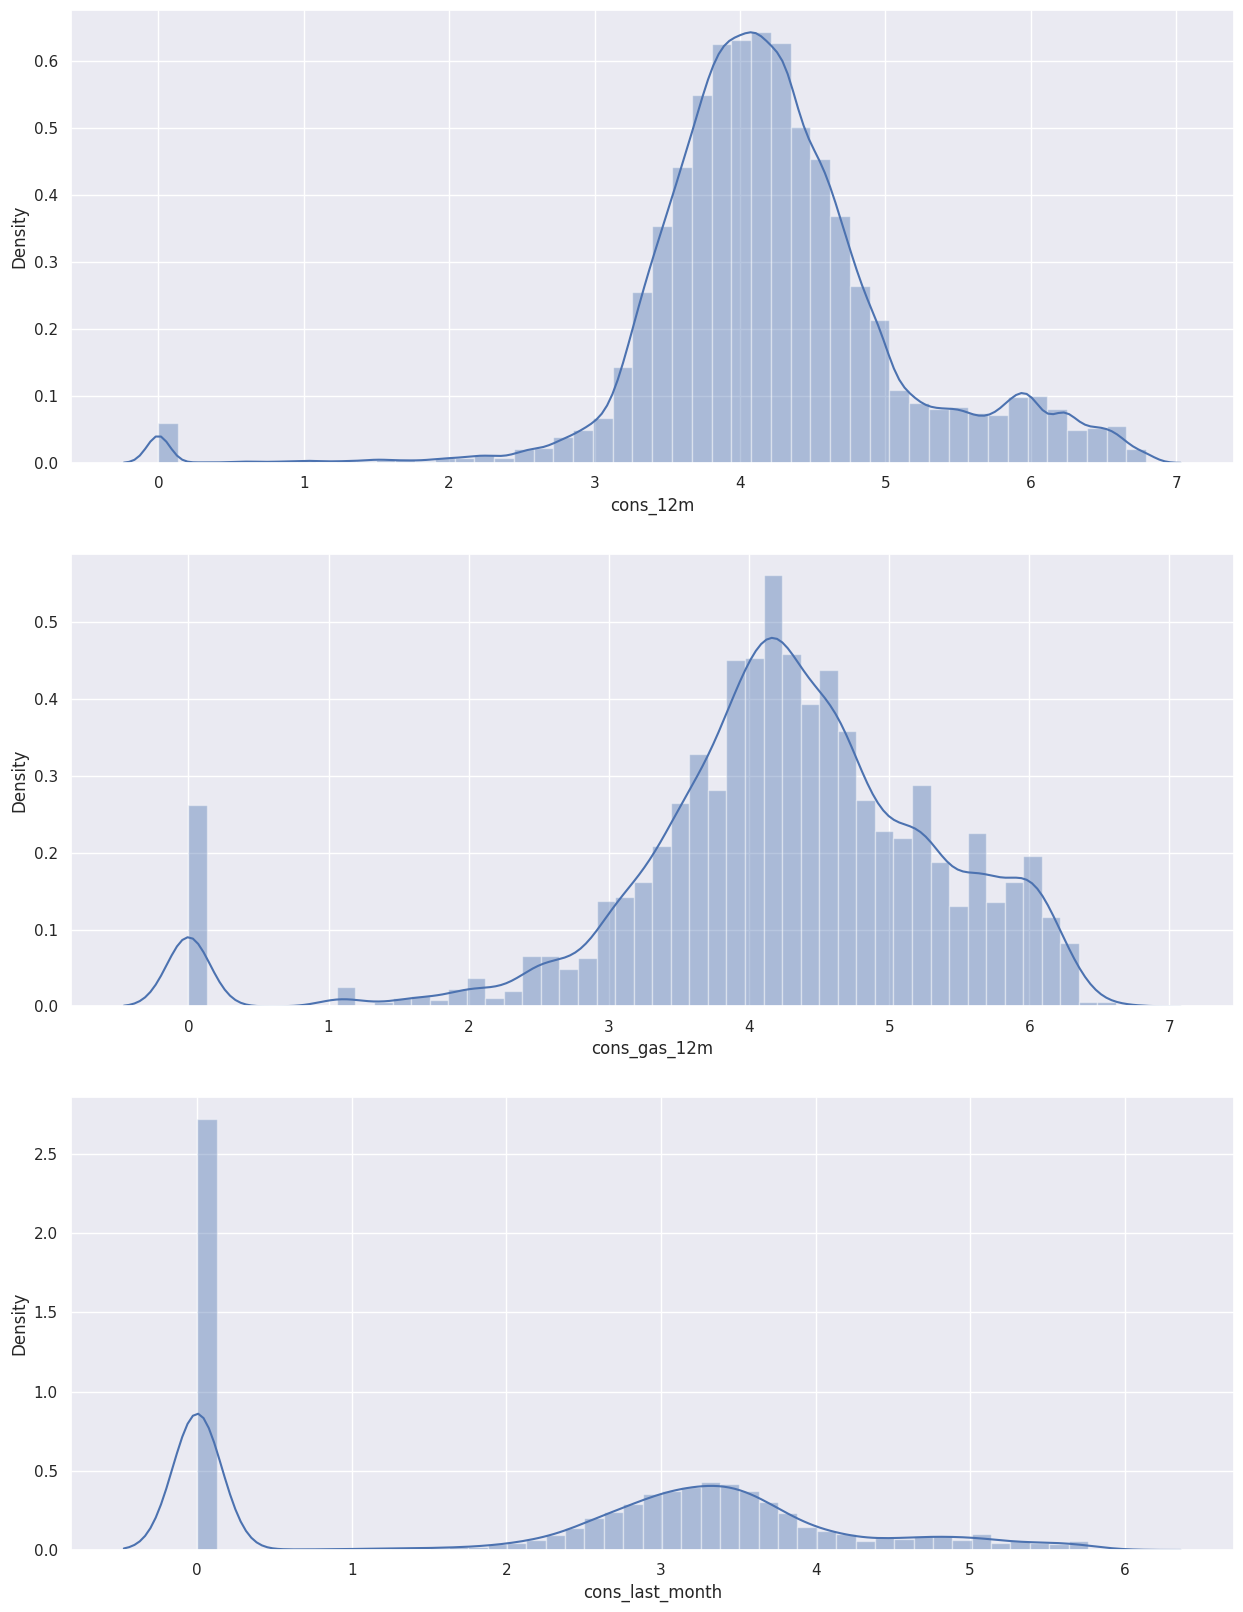

In [72]:
fig, axs = plt.subplots(nrows=3, figsize=(15, 20))
sns.distplot((df["cons_12m"].dropna()), ax=axs[0])
sns.distplot((df[df["has_gas"]==1]["cons_gas_12m"].dropna()), ax=axs[1])
sns.distplot((df["cons_last_month"].dropna()), ax=axs[2])
plt.show()
     

Correlations:
---
In order to know which one to keep and which features to drop

In [76]:

correlation = df.corr()
plt.figure(figsize=(50, 50))
sns.heatmap(
    correlation, 
    xticklabels=correlation.columns.values,
    yticklabels=correlation.columns.values, 
    annot=True, 
    annot_kws={'size': 10}
)

plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.show()

Output hidden; open in https://colab.research.google.com to view.

In [77]:
#These two variables need to be removed because these too have high correlation to the independant varible.
df = df.drop(columns=['num_years_antig', 'forecast_cons_year'])
df.head()

,Unnamed: 0,id,cons_12m,cons_gas_12m,cons_last_month,forecast_cons_12m,forecast_discount_energy,forecast_meter_rent_12m,forecast_price_energy_off_peak,forecast_price_energy_peak,...,months_modif_prod,months_renewal,channel_MISSING,channel_ewpakwlliwisiwduibdlfmalxowmwpci,channel_foosdfpfkusacimwkcsosbicdxkicaua,channel_lmkebamcaaclubfxadlmueccxoimlema,channel_usilxuppasemubllopkaafesmlibmsdf,origin_kamkkxfxxuwbdslkwifmmcsiusiuosws,origin_ldkssxwpmemidmecebumciepifcamkci,origin_lxidpiddsbxsbosboudacockeimpuepw
0,0,24011ae4ebbe3035111d65fa7c15bc57,0.0,4.739944,0.0,0.0,0.0,0.444045,0.114481,0.098142,...,2,6,0,0,1,0,0,0,0,1
1,1,24011ae4ebbe3035111d65fa7c15bc57,0.0,4.739944,0.0,0.0,0.0,0.444045,0.114481,0.098142,...,2,6,0,0,1,0,0,0,0,1
2,2,24011ae4ebbe3035111d65fa7c15bc57,0.0,4.739944,0.0,0.0,0.0,0.444045,0.114481,0.098142,...,2,6,0,0,1,0,0,0,0,1
3,3,24011ae4ebbe3035111d65fa7c15bc57,0.0,4.739944,0.0,0.0,0.0,0.444045,0.114481,0.098142,...,2,6,0,0,1,0,0,0,0,1
4,4,24011ae4ebbe3035111d65fa7c15bc57,0.0,4.739944,0.0,0.0,0.0,0.444045,0.114481,0.098142,...,2,6,0,0,1,0,0,0,0,1


Implenting the ML Model:
---
We'd be using Random Forest classifier to with a 75%-25% split to train the model.

Insights:
- About 10.66% are Churners in the test
- False Negatives are Zero so we did what we set out for.
- The precision level is already 1 so it's a pretty good model.


In [85]:

train_df = df.copy()
y = df['churn']
X = df.drop(columns=['Unnamed: 0','forecast_meter_rent_12m','id', 'churn'])
print(X.shape)
print(y.shape)

(175149, 48)
(175149,)


In [94]:

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)


(131361, 48)
(131361,)
(43788, 48)
(43788,)


Model Traning

In [88]:
model = RandomForestClassifier(
    n_estimators=1000
)
model.fit(X_train, y_train)

RandomForestClassifier(n_estimators=1000)

Model Evaluation

In [89]:
predictions = model.predict(X_test)
tn, fp, fn, tp = metrics.confusion_matrix(y_test, predictions).ravel()
y_test.value_counts()

0    39568
1     4220
Name: churn, dtype: int64

In [90]:

print(f"True positives: {tp}")
print(f"False positives: {fp}")
print(f"True negatives: {tn}")
print(f"False negatives: {fn}\n")

print(f"Accuracy: {metrics.accuracy_score(y_test, predictions)}")
print(f"Precision: {metrics.precision_score(y_test, predictions)}")
print(f"Recall: {metrics.recall_score(y_test, predictions)}")
     

True positives: 4220
False positives: 0
True negatives: 39568
False negatives: 0

Accuracy: 1.0
Precision: 1.0
Recall: 1.0


ML Model Understanding:
---
Insights:
- Consumption & Net Margin of 12 Months is the top Margin for the churn.
- Margin on Power subcription is also an influential feature.
- Time also seems to be an influential factor.
- Price Sensitivity is scattered around various factors but not the most important one.

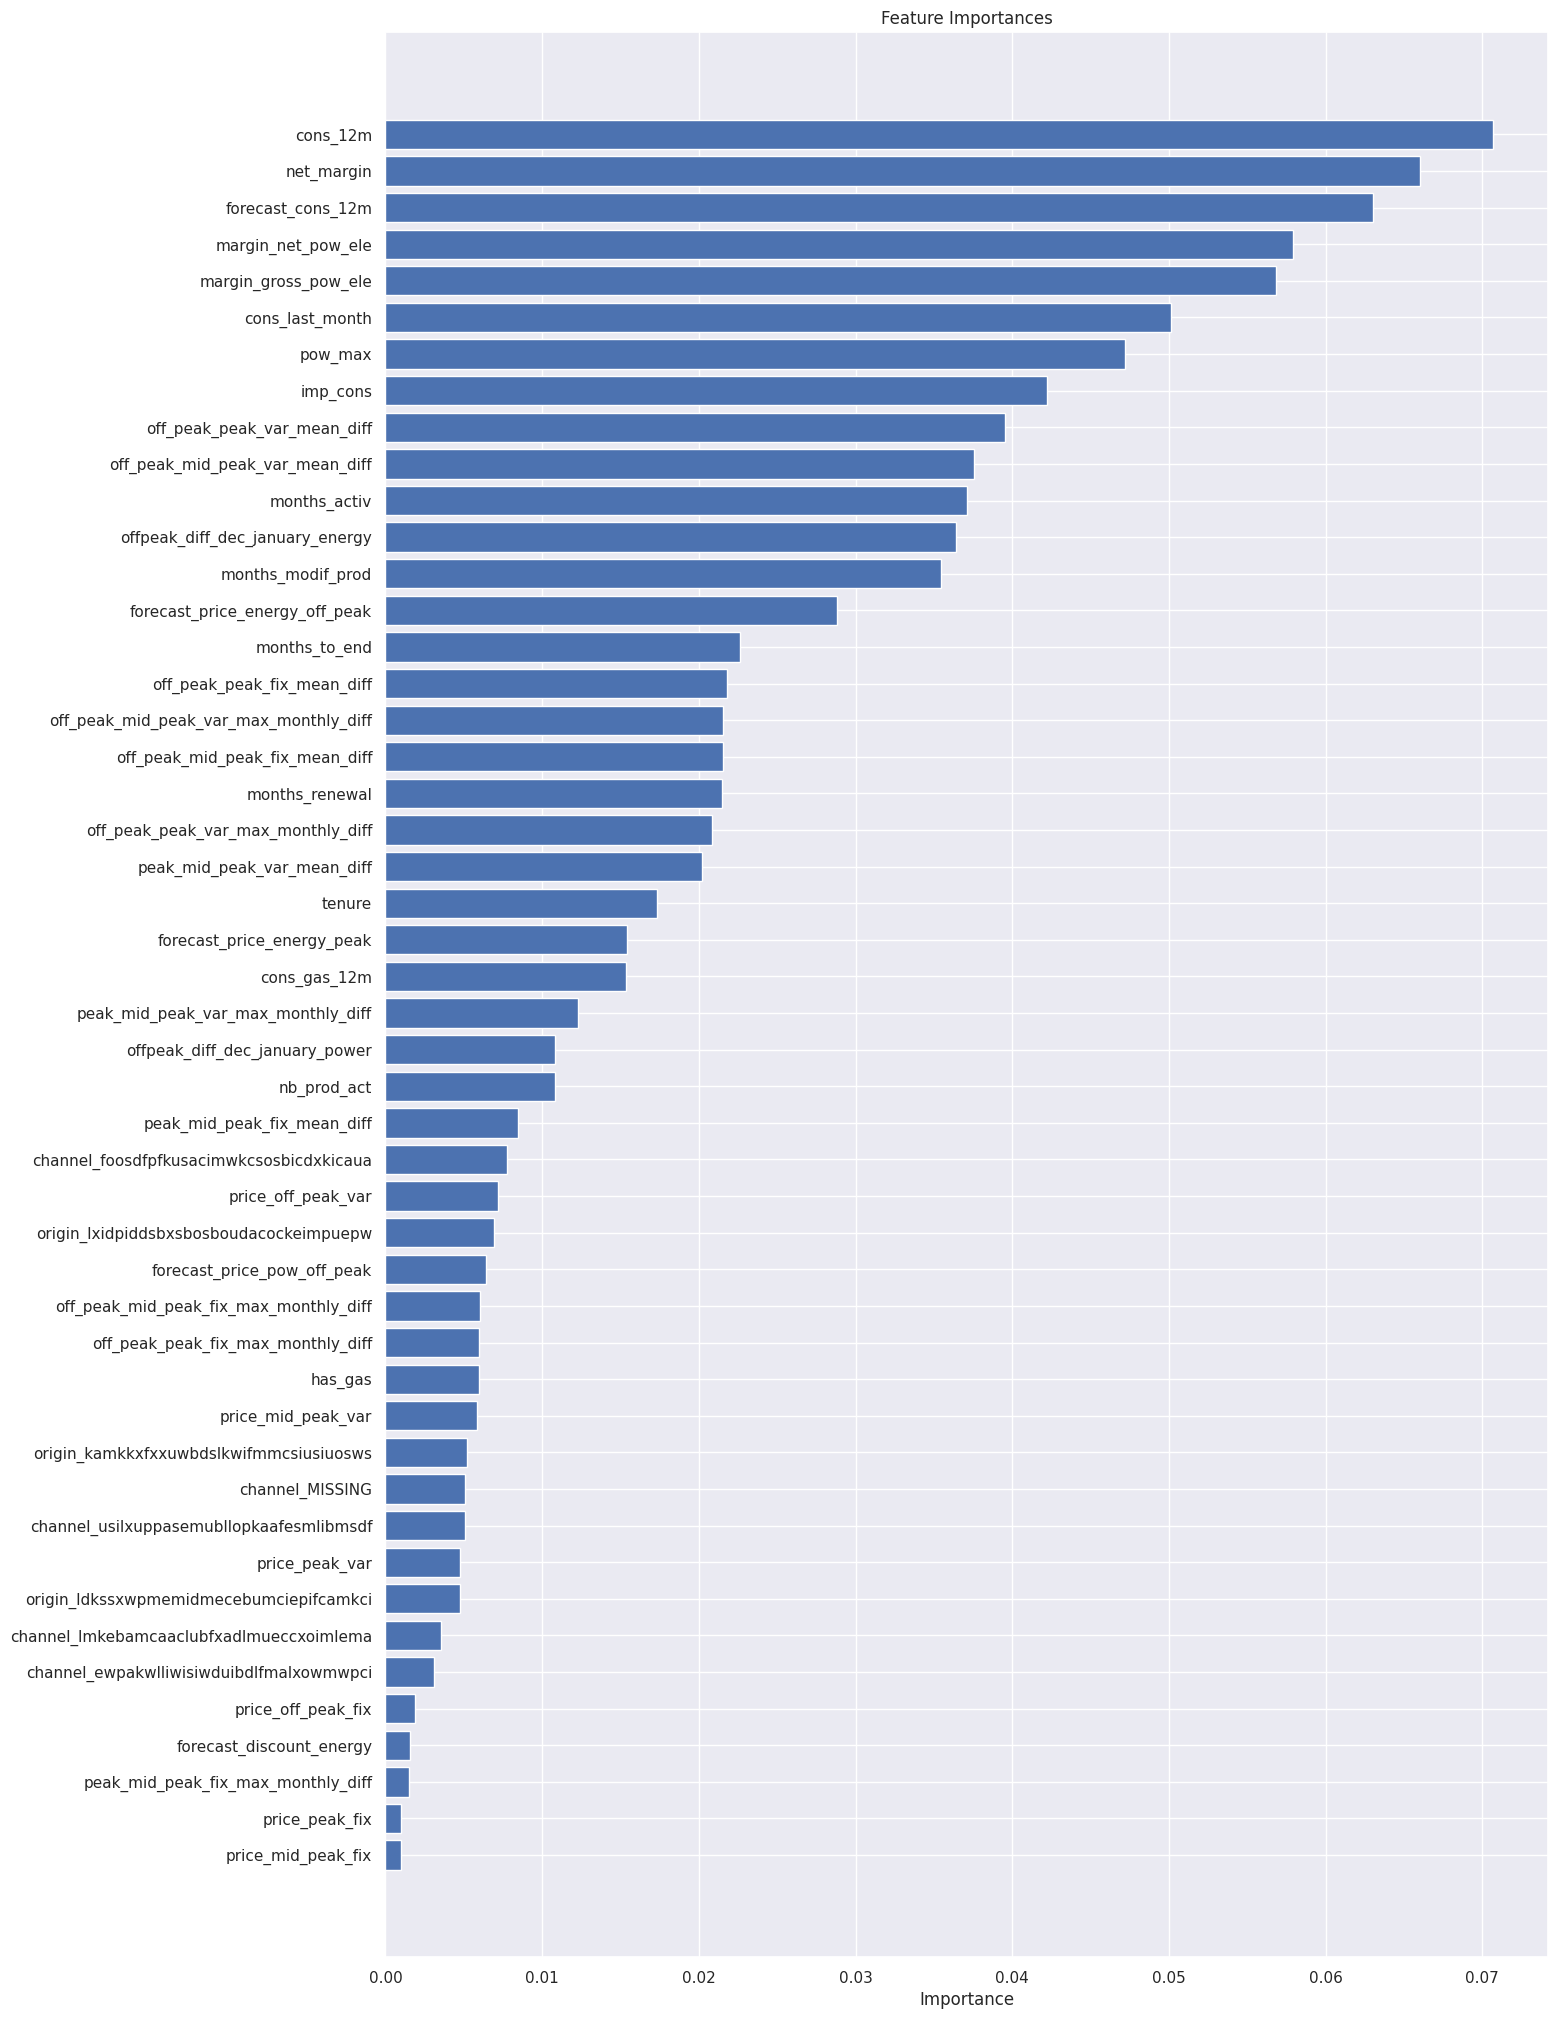

In [103]:
feature_importances = pd.DataFrame({
    'features': X_train.columns,
    'importance': model.feature_importances_
}).sort_values(by='importance', ascending=True).reset_index()

    
plt.figure(figsize=(15, 25))
plt.title('Feature Importances')
plt.barh(range(len(feature_importances)), feature_importances['importance'], color='b', align='center')
plt.yticks(range(len(feature_importances)), feature_importances['features'])
plt.xlabel('Importance')
plt.show()
     

On to the Final Conclusion: Hypothesis
---
Is churn driven by customers Price sensitivity?

- No its not the most important feature but a weak contributor and it's scatered around Various features.